### Финальный проект
##### Представьте, что вы работаете в компании, которая разрабатывает мобильные игры. К вам пришел менеджер с рядом задач по исследованию нескольких аспектов мобильного приложения:
1. В первую очередь, его интересует показатель retention. Напишите функцию для его подсчета.
2. Помимо этого, в компании провели A/B тестирование наборов акционных предложений. На основе имеющихся данных определите, какой набор можно считать лучшим и на основе каких метрик стоит принять правильное решение.
3. Предложите метрики для оценки результатов последнего прошедшего тематического события в игре.

##### Задание 1
Написать функцию, которая будет считать retention игроков (по дням от даты регистрации игрока).

Сначала загрузим и просмотрим данные двух таблиц. Зададим правильный формат колонкам, заменим формат UNIX time на привычный.

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import datetime
from scipy.stats import norm, mannwhitneyu
import matplotlib.pyplot as plt
import scipy.stats as st

from tqdm.auto import tqdm

%matplotlib inline

In [2]:
reg_data = pd.read_csv('~/shared/problem1-reg_data.csv', sep=';')
reg_data['reg_ts'] = pd.to_datetime(reg_data['reg_ts'], unit='s')
# reg_data.head()

In [3]:
reg_data.dtypes # проверяем, что тип данных отражен корректно

reg_ts    datetime64[ns]
uid                int64
dtype: object

In [4]:
# определяем, за какой период регистрировались пользователи
print(reg_data['reg_ts'].min()) 
print(reg_data['reg_ts'].max())

1998-11-18 09:43:43
2020-09-23 15:17:24


In [5]:
auth_data = pd.read_csv('~/shared/problem1-auth_data.csv', sep=';')
auth_data['auth_ts'] = pd.to_datetime(auth_data['auth_ts'], unit='s')
# auth_data.head()

In [6]:
auth_data.dtypes # проверяем, что тип данных отражен корректно

auth_ts    datetime64[ns]
uid                 int64
dtype: object

In [7]:
# определяем, за какой период пользователи заходили в игру
print(auth_data['auth_ts'].min())
print(auth_data['auth_ts'].max())

1998-11-18 09:43:43
2020-09-23 15:17:24


Дата первой регистрации совпадает с датой первого захода пользователей в игру: 1998-11-18

Дата последней регистрации также совпадает с датой последнего захода пользователей в игру: 2020-09-23

Таким образом, у нас есть данные за период с 1998-11-18 по 2020-09-23

Протестируем работу функции на части данных. Для анализа возьмем период с 2020-08-24 по 2020-09-23

In [8]:
# данные о регистрации за 2020-08-24 - 2020-09-23
reg_data = reg_data.query('reg_ts >= "2020-08-24"')

In [9]:
# данные о времени захода пользователей в игру за 2020-08-24 - 2020-09-23
auth_data = auth_data.query('auth_ts >= "2020-08-24"')

Для удобства объединим данные в датафрейм, где по каждому пользователю будут данные о дате регистрации и времени захода в игру:

In [10]:
data = pd.DataFrame
data = reg_data.merge(auth_data, how = 'left', on = 'uid')
data['reg_ts'] = pd.to_datetime(data['reg_ts']).dt.date # приведем дату к удобному для дальнейшей работы формату
data['auth_ts'] = pd.to_datetime(data['auth_ts']).dt.date
data.head()

,reg_ts,uid,auth_ts
0,2020-08-24,1056092,2020-08-24
1,2020-08-24,1056092,2020-08-29
2,2020-08-24,1056092,2020-08-31
3,2020-08-24,1056092,2020-09-06
4,2020-08-24,1056092,2020-09-12





Функция для расчета retention:

In [11]:
def retention (data):

    # Определим количество дней, прошедших после регистрации до времени захода в игру
    data['days_passed'] = (data['auth_ts'] - data['reg_ts']).dt.days

    # Сгруппируем данные для построения сводной таблицы
    data = data.groupby(['reg_ts', 'days_passed'], as_index=False).agg({'uid': 'nunique'}).rename({'reg_ts': 'cohort'}, axis=1)

    # Построим сводную таблицу
    data_pivot = pd.pivot_table(data, values='uid', index='cohort', columns='days_passed')
    # Переведем количество пользователей в доли с помощью divide
    data_pivot = data_pivot.div(data_pivot[0], axis=0)

    # Построим график
    sns.set_style("whitegrid")
    plt.figure(figsize=(20,14))
    plt.title('Users retention by days', size=16)
    # Зададим такие минимальные и максимальные значения для цвета, чтобы тепловая карта была наглядной
    sns.heatmap(data_pivot, robust=True, annot=True, fmt='.0%', vmin=0.01,vmax=0.1, cmap='BuGn', cbar=False)

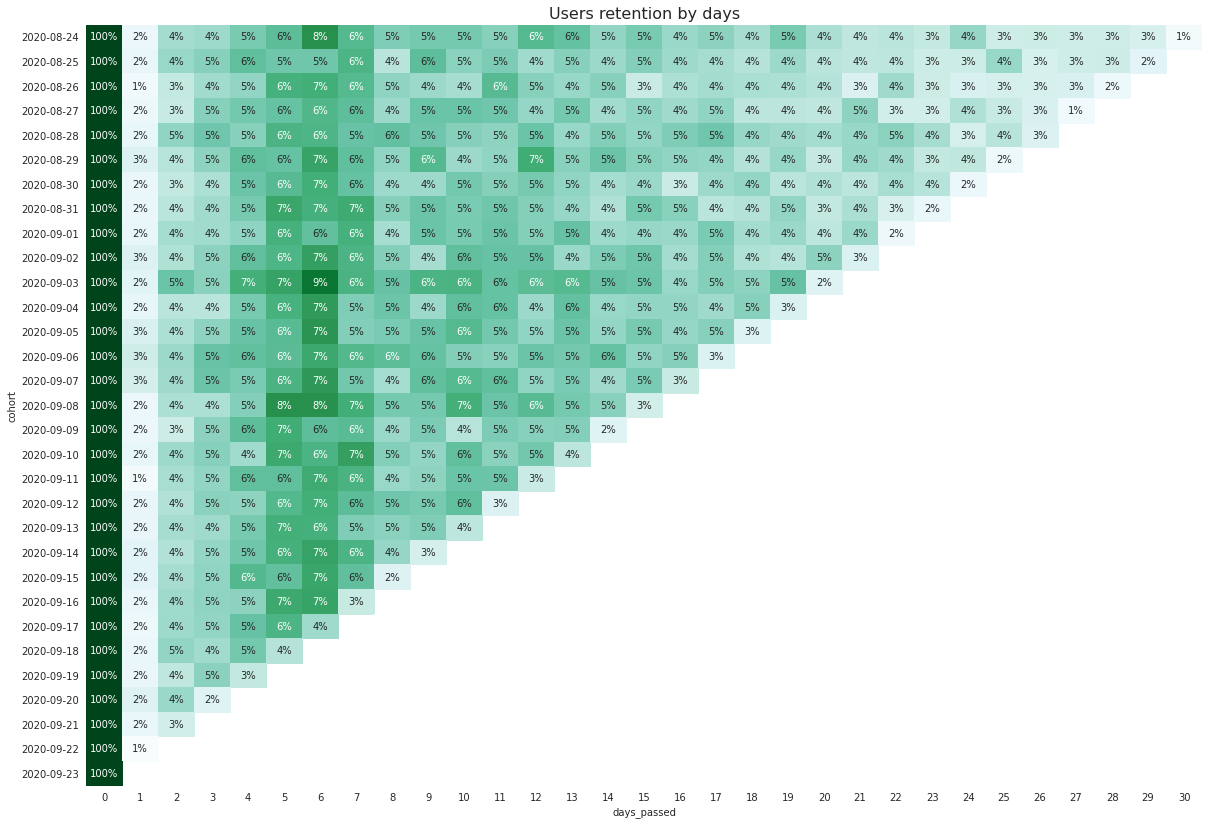

In [12]:
Users_retention_by_days = retention(data)

Когортный анализ данных за период с 24 августа 2020 года по 23 сентября 2020 года позволяет сделать вывод о том, что наиболее высокий коэффициент удержания наблюдается на 5-7 день, уже начиная с 14 дня идет значительное снижение вовлеченности пользователей. 

Для выявления явных причин снижения вовлеченности необходимо провести дальнейшие исследования, позволяющие определить, связано ли падение вовлеченности с такими факторами, как сезонность, удобство использования приложения и др. Любопытными для анализа данными могут быть: время посещения приложения, время проведенное в приложении, количество посещений одним пользователем в день.

Начиная со второй недели после регистрации следует начать взаимодействие с пользователями с целью поощрения их к целевому действию (использованию приложения).

---

##### Задание 2
Имеются результаты A/B теста, в котором двум группам пользователей предлагались различные наборы акционных предложений. Известно, что ARPU в тестовой группе выше на 5%, чем в контрольной. При этом в контрольной группе 1928 игроков из 202103 оказались платящими, а в тестовой – 1805 из 202667.

Какой набор предложений можно считать лучшим? Какие метрики стоит проанализировать для принятия правильного решения и как?

Загрузим данные и проанализируем их:

In [40]:
bonus = pd.read_csv('~/shared/problem2.csv', sep=';')
bonus.head()

,user_id,revenue,testgroup
0,1,0,b
1,2,0,a
2,3,0,a
3,4,0,b
4,5,0,b


In [41]:
bonus.info() # посмотрим на размер датафрейма, тип данных, наличие пустых значений

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404770 entries, 0 to 404769
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   user_id    404770 non-null  int64 
 1   revenue    404770 non-null  int64 
 2   testgroup  404770 non-null  object
dtypes: int64(2), object(1)
memory usage: 9.3+ MB


In [6]:
# Посмотрим на распределение пользователей по группам
bonus.testgroup.value_counts()

b    202667
a    202103
Name: testgroup, dtype: int64

Тестовая и контрольная группа примерно равны. Из условия известно, что:

а - контрольная группа,
b - тестовая группа

In [7]:
# Сформируем отдельные датафреймы для групп пользователей

In [8]:
bonus_a = bonus.query('testgroup == "a"')
# bonus_a.head()

In [9]:
bonus_b = bonus.query('testgroup == "b"')
# bonus_b.head()

Для анализа **ARPU (Average revenue per user)** среднего дохода с привлечённого пользователя разложим метрику на составляющие:

ARPU = Конверсия * ARPPU

Конверсия = Число клиентов / Число пользователей

ARPPU = Доход / Число клиентов

In [10]:
# Клиент = платящий пользователь (чья выручка имеет положительное значение)
# Посчитаем их количество для каждой из групп

In [11]:
client_a = bonus_a.query('revenue > 0').user_id.count()
client_a

1928

In [12]:
client_b = bonus_b.query('revenue > 0').user_id.count()
client_b

1805

In [13]:
# Количество пользователей

In [14]:
user_a = bonus.query('testgroup == "a"').user_id.count()
user_a

202103

In [15]:
user_b = bonus.query('testgroup == "b"').user_id.count()
user_b

202667

In [16]:
# Найдем конверсию пользователей в покупателей для контрольной группы

In [17]:
cr_a = round(client_a / user_a * 100, 2)
cr_a

0.95

In [18]:
# Найдем конверсию пользователей в покупателей для тестовой группы

In [19]:
cr_b = round(client_b / user_b * 100, 2)
cr_b

0.89

In [20]:
# Для определения среднего дохода на клиента поделим общую выручку на число клиентов

In [21]:
ARPPU_a = round(bonus_a.revenue.sum() / client_a)
ARPPU_a

2664

In [22]:
ARPPU_b = round(bonus_b.revenue.sum() / client_b)
ARPPU_b

3004

In [23]:
# Рассчитаем ARPU

In [24]:
ARPU_a = round(cr_a * ARPPU_a)
ARPU_a

2531

In [25]:
ARPU_b = round(cr_b * ARPPU_b)
ARPU_b

2674

По условию известно, что ARPU в тестовой группе выше на 5%, чем в контрольной (рассчитаем темп прироста относительно контрольной группы):

In [26]:
round(((ARPU_b / ARPU_a) * 100) - 100, 2)

5.65

In [27]:
# Cравним процент платящих пользователей в группах:
round(cr_a - cr_b, 2)

0.06

Анализ ARPU показал, что средний доход с клиента выше в тестовой группе на 5,65%, а процент платящик пользователей незначительно выше в контрольной группе на 0,06%.

Однако этих данных недостаточно для принятия окончательного решения относительно выбора набора акционных предложений. 

Cравним значения выборок при помощи статистических методов.

Так как процент неактивных пользователей намного превышает процент платящих клиентов, использование всего массива данных сильно исказит статистические значения.

Проведем структурный анализ выручки для платящих клиентов.

In [28]:
bonus_a.query('revenue > 0').revenue.describe().round()

count     1928.0
mean      2664.0
std       9049.0
min        200.0
25%        257.0
50%        311.0
75%        361.0
max      37433.0
Name: revenue, dtype: float64

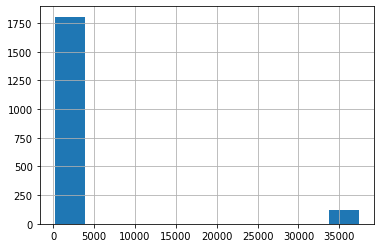

In [29]:
# Распределение значений выручки для контрольной группы
bonus_a.query('revenue > 0').revenue.hist()

In [30]:
bonus_b.query('revenue > 0').revenue.describe().round()

count    1805.0
mean     3004.0
std       573.0
min      2000.0
25%      2513.0
50%      3022.0
75%      3478.0
max      4000.0
Name: revenue, dtype: float64

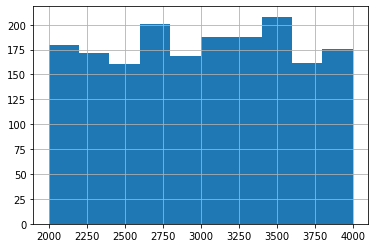

In [31]:
# Распределение значений выручки для тестовой группы
bonus_b.query('revenue > 0').revenue.hist()

Посмотрим на данные и графики. Полученное распределение не является нормальным.

Данные групп сильно различаются между собой. 

Имеется большое различие между значениями стандартного отклонения в группах, которое показывает реальную среднюю разницу каждого значения и среднего в выборке. При этом стандартное отклонение тестовой группы **573** в разы меньше значения контрольной группы **9049**.

В **контрольной группе** наблюдается сильный разброс данных, числа далеки от среднего показателя, значения волатильны. Минимальное значение выручки составляет **200**, максимальное значение **37433**. Среднее значение отражает реальную картину, так как по графику видно, что большинство наблюдений расположены возле него.

Для **тестовой группы** среднее значение **3004** отражает реальное среднее между минимальным значением **2000** и максимальным **4000**.

В качестве базового метода целесообразно использовать тест Стьюдента, так как он больше всего подходит для больших выборок, что позволяет не учитывать ненормальность распределений.

Существенное отличие t-теста в том, что он предполагает соблюдение предположения о независимости выборок.

Проверим, являются ли дисперсии внутри групп примерно одинаковыми (гомогенными) с помощью теста Левена.

In [33]:
# сгруппируем данные выручки для контрольной и тестовой групп
A = bonus_a.query('revenue > 0').revenue
B = bonus_b.query('revenue > 0').revenue

In [34]:
st.levene(A, B)

LeveneResult(statistic=80.85567421779912, pvalue=3.779689868667878e-19)

Выборки однородны, так как p-value > 0.05, не отклоняем нулевую гипотезу.

Посмотрим на нормальность распределений в выборках. normaltest() адаптирован к большим выборкам, будем использовать его.

In [36]:
st.normaltest(A)

NormaltestResult(statistic=1394.9457843086925, pvalue=1.2341605505935488e-303)

In [37]:
st.normaltest(B)

NormaltestResult(statistic=1068.8600084412267, pvalue=7.943249488371762e-233)

Распределение revenue является нормальным для контрольной и тестовой групп. Для сравнения средних в данных экспериментальных группах используем тест Стьюдента.


Проведем **t-тест** и сформулируем гипотезы для проверки:

Нулевая гипотеза (H0): Разницы между средней выручкой в тестовой и контрольной группе клиентов нет

Альтернативная гипотеза (H1): Разница между средней выручкой в тестовой и контрольной группе клиентов есть

In [38]:
st.ttest_ind(A, B)

Ttest_indResult(statistic=-1.5917100176862002, pvalue=0.11153459157259504)

p-value больше 0.05, следовательно t-тест показывает, что контрольные и тестовые значения одинаковы.

Нулевая гипотеза принимается.

**Выводы по результатам анализа:**

На основании проведенного анализа была принята нулевая гипотеза об отсутствии различий между тестовой и контрольной выборками. Средняя выручка клиентов статистически значимо не различается для контрольной и тестовой групп.

Для исследования пакета акционных предложений можно рассмотреть структуру предложенных акций, имеются ли совпадения в составляющих, являются ли предлагаемые опции комплементарными, одинаковы ли по стоимости. На основании исследования набора предложений можно будет сделать дополнительные выводы о целесообразности сформированного для пользователя предложения. 







---

##### Задание 3
В игре Plants & Gardens каждый месяц проводятся тематические события, ограниченные по времени. В них игроки могут получить уникальные предметы для сада и персонажей, дополнительные монеты или бонусы. Для получения награды требуется пройти ряд уровней за определенное время. С помощью каких метрик можно оценить результаты последнего прошедшего события?

Предположим, в другом событии мы усложнили механику событий так, что при каждой неудачной попытке выполнения уровня игрок будет откатываться на несколько уровней назад. Изменится ли набор метрик оценки результата? Если да, то как?

Для мобильных игр и приложений метрики удобно отслеживать через одну конкретную единицу (пользователя). Для оценки результата последнего прошедшего события для каждого пользователя можно использовать:

    Время, за которое был пройдет один уровень
    
    Количество собранных монет/бонусов за определенное время
    
    Количество собранных монет/бонусов за один уровень
    
    Максимальное количество пройденных уровней за определенное время
    
    Количество пройденных уровней в день/месяц
    
    Время, проведенное в игре за день/месяц
    
    Количество дней между переходом к следующему уровню
    
    
Оценить поведение аудитории помогут показатели:

    Дневная аудитория (DAU)
    
    Средняя дневная аудитория
    
    Месячная аудитория (MAU)
    
    Количество новых/отвалившихся/вернувшихся пользователей
    
    Доля новых пользователей
    
    avg. DAU/MAU = stickness ratio
    
    Retention
    
    Churn rate
    

В качестве гипотезы предлагается оценить, как поведение пользователя повлияет на изменение других метрик и набор метрик для оценки результата. При усложнении механики стоит понаблюдать, не изменится ли уровень вовлеченности пользователя. Если изменение произойдет, то будет целесообразным посмотреть, в какой момент времени и сопоставим ли этот коэффициент удержания с базовой версией игры. 

Чтобы оценить результат, необходимо дополнительно посмотреть:

    Количество пользователей, дошедших до конца события спустя некоторое количество неудачных попыток
    
    Отписки и увеличение/падение активности 
    
    Сохранилось ли число уникальных пользователей в день, заходящих в игру
    
    Количество заходов в игру в день
    
    Как изменилась длина сессии в игре
    
    Количество загрузок игры